In [2]:
import os
#os.environ['USE_CUDA'] = str(0)
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import torch.backends.cudnn as cudnn
import torchvision.utils as vutils
cudnn.benchmark = True

# some utility function for visualization
import utils
from utils.util_3d import init_mesh_renderer, sdf_to_mesh

# some utility function
from utils.qual_util import save_mesh_as_gif
from IPython.display import Image as ipy_image
from IPython.display import display

%reload_ext autoreload
%autoreload 2

environ({'CHROME_DESKTOP': 'code-url-handler.desktop', 'CINNAMON_VERSION': '5.4.12', 'CONDA_DEFAULT_ENV': 'autosdf', 'CONDA_EXE': '/home/alessandro/anaconda3/bin/conda', 'CONDA_PREFIX': '/home/alessandro/anaconda3/envs/autosdf', 'CONDA_PROMPT_MODIFIER': '(autosdf) ', 'CONDA_PYTHON_EXE': '/home/alessandro/anaconda3/bin/python', 'CONDA_SHLVL': '2', 'DBUS_SESSION_BUS_ADDRESS': 'unix:path=/run/user/1000/bus', 'DEFAULTS_PATH': '/usr/share/gconf/cinnamon.default.path', 'DESKTOP_SESSION': 'cinnamon', 'DISPLAY': ':0', 'GDK_BACKEND': 'x11', 'GDMSESSION': 'cinnamon', 'GDM_LANG': 'it', 'GIO_LAUNCHED_DESKTOP_FILE': '/usr/share/applications/code.desktop', 'GIO_LAUNCHED_DESKTOP_FILE_PID': '3109', 'GJS_DEBUG_OUTPUT': 'stderr', 'GJS_DEBUG_TOPICS': 'JS ERROR;JS LOG', 'GNOME_DESKTOP_SESSION_ID': 'this-is-deprecated', 'GPG_AGENT_INFO': '/run/user/1000/gnupg/S.gpg-agent:0:1', 'GTK3_MODULES': 'xapp-gtk3-module', 'GTK_MODULES': 'gail:atk-bridge', 'GTK_OVERLAY_SCROLLING': '1', 'HOME': '/home/alessandro', 'LA

In [7]:
from utils.demo_util import get_shape_comp_opt, get_shape_comp_model
from utils.qual_util import load_resnet2vq_model

""" setup opt"""
gpu_id = 0

opt = get_shape_comp_opt(gpu_id=gpu_id)
opt.vq_note = 'default'
""" setup models """
model = get_shape_comp_model(opt)    
model.eval()

# img marginal model
resnet2vq = load_resnet2vq_model(opt)

""" setup renderer """
dist, elev, azim = 1.7, 20, 20
mesh_renderer = init_mesh_renderer(image_size=256, dist=dist, elev=elev, azim=azim, device=opt.device)

[*] Enc has Attn at i_level, i_block: 3, 0
Working with z of shape (1, 256, 8, 8, 8) = 131072 dimensions.
[*] Dec has Attn at i_level, i_block: 3, 0
[*] VQVAE: weight successfully load from: saved_ckpt/pvqvae-snet-all-LR1e-4-T0.2-rerun-epoch140.pth
[*] Model has been created: Rand-Transformer-Model
[*] "rand_tf" initialized.
[*] weight successfully load from: saved_ckpt/rand_tf-snet_code-all-LR1e-4-clean-epoch200.pth
[*] loading state_dict with strict=False!
[*] resnet18 successfully loaded from https://download.pytorch.org/models/resnet18-f37072fd.pth.


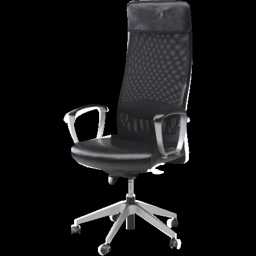

In [8]:
""" setup pix3d img dataset and image marginal model """
from utils.qual_util import load_resnet2vq_model, preprocess_img

# load and preprocess image
img_path = 'demo_data/chair_2598.jpg'
img_mask_path = 'demo_data/chair_2598_mask.png'

img_input = preprocess_img(img_path, img_mask_path)

#img_name = 'demo_data/tmp.png'
#vutils.save_image(img_input/2+.5, img_name)
#display(ipy_image(img_name))

In [15]:
""" single-view reconstruction """ 
nimgs = 3
topk = 10
alpha = 0.7

single_view_recon = model.single_view_recon(img_input, resnet2vq, bs=nimgs, topk=topk, alpha=alpha)

gen_mesh = sdf_to_mesh(single_view_recon)

# save as gif
# res_dir = 'results'
# gen_gif_name = f'{res_dir}/single-view-gen.gif'
# save_mesh_as_gif(mesh_renderer, gen_mesh, nrow=3, out_name=gen_gif_name)

# for name in [img_name, gen_gif_name]:
#    display(ipy_image(name))

[*] autoregressively inferencing...: 100%|██████████| 512/512 [11:36<00:00,  1.36s/it]


In [40]:
import pytorch3d
pytorch3d.io.save_obj("mesh.obj", verts=gen_mesh.verts_packed(), faces=gen_mesh.faces_packed())